# DCP Profile Primaries & Distance Limits



An exploratory notebook to compute DCP Profile primaries and their distance limits.

More information is available on [ACEScentral](https://community.acescentral.com/t/notice-of-meeting-aces-gamut-mapping-vwg-meeting-26-8-27-2020/).

## colour-science Requirements

In [ ]:
!pip install -q colour-hdri

!pip uninstall -y colour-science
!if ! [ -d "colour" ]; then git clone https://github.com/colour-science/colour; fi
!if [ -d "colour" ]; then cd colour && git fetch && git checkout develop && git pull && cd ..; fi

!python -c "import imageio;imageio.plugins.freeimage.download()"

Uninstalling colour-science-0.3.15:
  Successfully uninstalled colour-science-0.3.15
Already on 'develop'
Your branch is up to date with 'origin/develop'.
Already up to date.


In [ ]:
from __future__ import division, unicode_literals

import sys

sys.path.append('colour')

import colour
import glob
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import xml.etree.ElementTree as ET
from colour_hdri.models import (
    DNG_ILLUMINANTS_CORRELATED_COLOUR_TEMPERATURE,
    LIGHT_SOURCE_TAG_TO_DNG_ILLUMINANTS)
from copy import deepcopy
from tqdm import tqdm

np.set_printoptions(formatter={'float': '{:0.8f}'.format}, suppress=True)
pd.set_option('display.float_format', '{:0.8f}'.format)

colour.plotting.colour_style()

colour.utilities.describe_environment();

*                                                                             *
*   Interpreter :                                                             *
*       python : 3.6.9 (default, Jul 17 2020, 12:50:27)                       *
*                [GCC 8.4.0]                                                  *
*                                                                             *
*   colour-science.org :                                                      *
*       colour : v0.3.15-368-gb3a5b83b                                        *
*       colour-hdri : 0.1.7                                                   *
*                                                                             *
*   Runtime :                                                                 *
*       imageio : 2.4.1                                                       *
*       matplotlib : 3.2.2                                                    *
*       networkx : 2.5                  

colour/colour/utilities/verbose.py:237: ColourUsageWarning: "colour.colorimetry.ILLUMINANTS" object has been renamed to "colour.colorimetry.CCS_ILLUMINANTS".
  warn(*args, **kwargs)
colour/colour/utilities/verbose.py:237: ColourWarning: "Adobe DNG Converter" is not available on your platform!
  warn(*args, **kwargs)
colour/colour/utilities/verbose.py:237: ColourUsageWarning: "colour.models.sRGB_COLOURSPACE" object has been renamed to "colour.models.RGB_COLOURSPACE_sRGB".
  warn(*args, **kwargs)


# DCP Profile Dataset

In [ ]:
!gdown "https://drive.google.com/uc?id=10puzqHKq1tYCoQVqg8F2xu4SEM_rX3fF"
!unzip -o -q "DCP Profiles - Adobe Standard.zip" -d "DCP Profiles - Adobe Standard"

Downloading...
From: https://drive.google.com/uc?id=10puzqHKq1tYCoQVqg8F2xu4SEM_rX3fF
To: /content/DCP Profiles - Adobe Standard.zip
81.6MB [00:00, 197MB/s]


In [ ]:
ROOT_DIRECTORY = 'DCP Profiles - Adobe Standard'

DCP_PROFILES = glob.glob('{0}/*.xml'.format(ROOT_DIRECTORY))


def parse_3x3_matrix(matrix):
    values = []
    for row in range(3):
        for column in range(3):
            values.append(matrix.find(
               f'.//Element[@Row="{row}"][@Col="{column}"]').text)
    
    return colour.utilities.as_float_array(values).reshape([3, 3])


def colour_matrix_to_colourspace(matrix, uv):
    matrix = np.linalg.inv(matrix)

    primaries, _whitepoint = colour.primaries_whitepoint(matrix)
    colourspace = colour.RGB_Colourspace(
        'Undefined',
        primaries,
        colour.UCS_uv_to_xy(uv),
        use_derived_RGB_to_XYZ_matrix=True,
        use_derived_XYZ_to_RGB_matrix=True,
    )
    
    barycenter = colour.xy_to_XYZ(np.sum(primaries, axis=0) / 3)
    if np.any(barycenter < 0):
        return

    if np.allclose(primaries, np.array([[1, 0], [0, 1], [0, 0]])):
        return
    
    return colourspace


def parse_dcp_profile(dcp_profile):
    basename = os.path.splitext(os.path.basename(dcp_profile))[0]
    
    tree = ET.parse(dcp_profile)
    root = tree.getroot()

    calibration_illuminant_1 = int(root.find('CalibrationIlluminant1').text)
    CCT_1 = DNG_ILLUMINANTS_CORRELATED_COLOUR_TEMPERATURE[
        LIGHT_SOURCE_TAG_TO_DNG_ILLUMINANTS[calibration_illuminant_1]]
    uv_1 = colour.temperature.CCT_to_uv_Robertson1968([CCT_1, 0])
    color_matrix_1 = parse_3x3_matrix(root.find('ColorMatrix1'))
    colourspace_1 = colour_matrix_to_colourspace(color_matrix_1, uv_1)
    if colourspace_1 is None:
        print(
            f'{basename} profile "ColorMatrix1" is unsuitable, skipping!')
        return

    colourspace_1.name = f'{basename} - ColorMatrix1'
    
    calibration_illuminant_2 = int(root.find('CalibrationIlluminant2').text)
    CCT_2 = DNG_ILLUMINANTS_CORRELATED_COLOUR_TEMPERATURE[
        LIGHT_SOURCE_TAG_TO_DNG_ILLUMINANTS[calibration_illuminant_2]]
    uv_2 = colour.temperature.CCT_to_uv_Robertson1968([CCT_2, 0])
    color_matrix_2 = parse_3x3_matrix(root.find('ColorMatrix2'))
    colourspace_2 = colour_matrix_to_colourspace(color_matrix_2, uv_2)
    if colourspace_2 is None:
        print(
            f'{basename} profile "ColorMatrix2" is unsuitable, skipping!')
        return


    colourspace_2.name = f'{basename} - ColorMatrix2'

    return {
        'CalibrationIlluminant1': calibration_illuminant_1,
        'CCT1': CCT_1,
        'uv1': uv_1,
        'CalibrationIlluminant2': calibration_illuminant_2,
        'CCT2': CCT_2,
        'uv2': uv_2,
        'ColorMatrix1': color_matrix_1,
        'Colourspace1': colourspace_1,
        'ColorMatrix2': color_matrix_2,
        'Colourspace2': colourspace_2,
    }

DATA_DCP_PROFILES = {}

with tqdm(total=len(DCP_PROFILES)) as progress:
    for dcp_profile in DCP_PROFILES:        
        basename = os.path.splitext(os.path.basename(dcp_profile))[0]

        data_profile = parse_dcp_profile(dcp_profile)
        
        if data_profile is not None:
            DATA_DCP_PROFILES[basename] = data_profile

        progress.update(1)

  2%|▏         | 17/850 [00:01<01:00, 13.74it/s]

Panasonic DMC-FZ40 Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!


  4%|▍         | 32/850 [00:02<00:55, 14.81it/s]

Canon EOS 50D Adobe Standard profile "ColorMatrix2" is unsuitable, skipping!
Canon PowerShot Pro70 Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!


  4%|▍         | 37/850 [00:02<00:51, 15.66it/s]

Phase One P40+ Adobe Standard profile "ColorMatrix2" is unsuitable, skipping!
Leica D-LUX 3 Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!


  5%|▍         | 39/850 [00:02<01:01, 13.11it/s]

HUAWEI P30 Rear Main Camera Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!
Canon EOS-1Ds Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!


  6%|▌         | 47/850 [00:03<00:58, 13.64it/s]

Phase One IQ3 100MP Trichr Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!


  8%|▊         | 64/850 [00:04<00:55, 14.10it/s]

Phase One IQ140 Adobe Standard profile "ColorMatrix2" is unsuitable, skipping!


  8%|▊         | 72/850 [00:05<00:56, 13.81it/s]

Nikon Coolpix P1000 Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!
Fujifilm XF10 Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!


 10%|▉         | 81/850 [00:05<00:50, 15.22it/s]

Phase One IQ160 Adobe Standard profile "ColorMatrix2" is unsuitable, skipping!
Canon EOS 500D Adobe Standard profile "ColorMatrix2" is unsuitable, skipping!


 10%|█         | 85/850 [00:06<00:49, 15.33it/s]

Leaf Aptus 65S Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!


 10%|█         | 89/850 [00:06<00:53, 14.29it/s]

Samsung EX2F Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!
Hasselblad 39-Coated Adobe Standard profile "ColorMatrix2" is unsuitable, skipping!


 12%|█▏        | 103/850 [00:07<00:50, 14.75it/s]

Leaf Aptus 65 Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!
Phase One IQ3 100MP Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!


 14%|█▎        | 115/850 [00:08<00:47, 15.44it/s]

Fujifilm FinePix S100FS Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!
Leica V-LUX 1 Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!


 15%|█▍        | 125/850 [00:08<00:58, 12.49it/s]

Panasonic DC-G9 Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!


 16%|█▌        | 135/850 [00:09<00:54, 13.01it/s]

GoPro HERO7 Black Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!


 17%|█▋        | 146/850 [00:10<00:52, 13.33it/s]

Leaf Valeo 22 Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!


 20%|█▉        | 166/850 [00:12<00:50, 13.60it/s]

Fujifilm IS-1 Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!


 23%|██▎       | 194/850 [00:14<00:48, 13.60it/s]

Phase One P25 Adobe Standard profile "ColorMatrix2" is unsuitable, skipping!


 24%|██▍       | 207/850 [00:14<00:37, 17.01it/s]

Phase One P45 Adobe Standard profile "ColorMatrix2" is unsuitable, skipping!
Phase One P30 Adobe Standard profile "ColorMatrix2" is unsuitable, skipping!


 26%|██▌       | 218/850 [00:15<00:42, 14.97it/s]

Panasonic DMC-LX2 Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!


 27%|██▋       | 230/850 [00:16<00:45, 13.62it/s]

Leaf AFi 65S Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!


 28%|██▊       | 234/850 [00:16<00:46, 13.28it/s]

Canon PowerShot S90 Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!


 30%|███       | 258/850 [00:18<00:36, 16.08it/s]

Leica D-LUX 5 Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!
Sony DSLR-A550 Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!


 32%|███▏      | 273/850 [00:19<00:43, 13.37it/s]

Leaf Credo 60 Adobe Standard profile "ColorMatrix2" is unsuitable, skipping!
Fujifilm X-A5 Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!


 34%|███▍      | 288/850 [00:20<00:38, 14.71it/s]

Mamiya M31 Adobe Standard profile "ColorMatrix2" is unsuitable, skipping!


 35%|███▍      | 297/850 [00:21<00:40, 13.72it/s]

Leaf Aptus 54S Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!


 35%|███▌      | 299/850 [00:21<00:37, 14.71it/s]

Leaf Valeo 11 Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!


 36%|███▌      | 305/850 [00:21<00:33, 16.10it/s]

Panasonic DMC-LX3 Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!
Canon EOS-1D Adobe Standard profile "ColorMatrix2" is unsuitable, skipping!


 38%|███▊      | 327/850 [00:23<00:33, 15.77it/s]

Canon PowerShot A5 Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!


 40%|███▉      | 339/850 [00:23<00:35, 14.31it/s]

Panasonic DMC-FZ150 Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!


 40%|████      | 343/850 [00:24<00:33, 15.00it/s]

Phase One IQ250 Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!
Leaf Aptus 75S Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!


 42%|████▏     | 355/850 [00:25<00:36, 13.70it/s]

Mamiya ZD Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!


 44%|████▎     | 371/850 [00:26<00:35, 13.51it/s]

Canon PowerShot G15 Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!


 45%|████▌     | 383/850 [00:27<00:33, 13.89it/s]

Phase One IQ3 50MP Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!


 46%|████▋     | 395/850 [00:28<00:30, 14.86it/s]

Phase One IQ150 Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!
Leaf Valeo 6 Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!


 51%|█████     | 430/850 [00:30<00:30, 13.61it/s]

Leaf AFi 75S Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!
Panasonic DMC-FZ50 Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!


 52%|█████▏    | 444/850 [00:31<00:26, 15.30it/s]

Leaf C-Most Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!
Leaf Valeo 17 Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!


 56%|█████▌    | 474/850 [00:33<00:26, 14.08it/s]

Panasonic DMC-FZ200 Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!
Nikon Coolpix 5000 Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!
PENTAX K-x Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!


 56%|█████▌    | 478/850 [00:34<00:27, 13.73it/s]

PENTAX K-50 Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!


 57%|█████▋    | 482/850 [00:34<00:27, 13.34it/s]

Leaf AFi 54S Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!


 60%|█████▉    | 506/850 [00:36<00:23, 14.47it/s]

Nikon Coolpix 5700 Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!


 61%|██████    | 516/850 [00:36<00:23, 14.10it/s]

M9 Digital Camera Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!
Sony DSLR-A450 Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!


 61%|██████    | 520/850 [00:37<00:23, 13.95it/s]

Phase One H25 Adobe Standard profile "ColorMatrix2" is unsuitable, skipping!


 64%|██████▎   | 540/850 [00:38<00:24, 12.57it/s]

Canon PowerShot SX50 HS Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!


 64%|██████▍   | 544/850 [00:39<00:23, 13.27it/s]

PENTAX K-500 Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!


 66%|██████▌   | 560/850 [00:40<00:19, 15.23it/s]

Leica D-LUX 4 Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!


 67%|██████▋   | 568/850 [00:40<00:19, 14.62it/s]

Nikon Coolpix P950 Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!


 72%|███████▏  | 609/850 [00:43<00:16, 14.36it/s]

Phase One P65+ Adobe Standard profile "ColorMatrix2" is unsuitable, skipping!


 74%|███████▎  | 625/850 [00:45<00:15, 14.79it/s]

Leaf Aptus 22 Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!


 74%|███████▍  | 633/850 [00:45<00:17, 12.26it/s]

Canon PowerShot Pro90 IS Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!


 75%|███████▌  | 639/850 [00:46<00:16, 12.74it/s]

Canon PowerShot G1 Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!


 77%|███████▋  | 657/850 [00:47<00:14, 13.74it/s]

LEICA X2 Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!
Leaf Credo 80 Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!


 79%|███████▊  | 669/850 [00:48<00:12, 14.67it/s]

Leaf Credo 40 Adobe Standard profile "ColorMatrix2" is unsuitable, skipping!
Phase One P20 Adobe Standard profile "ColorMatrix2" is unsuitable, skipping!
Phase One P20+ Adobe Standard profile "ColorMatrix2" is unsuitable, skipping!


 81%|████████  | 685/850 [00:49<00:10, 15.65it/s]

Phase One IQ180 Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!
Phase One IQ3 60MP Adobe Standard profile "ColorMatrix2" is unsuitable, skipping!


 82%|████████▏ | 697/850 [00:50<00:10, 14.72it/s]

Canon PowerShot A50 Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!
Olympus SP-500UZ Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!


 82%|████████▏ | 699/850 [00:50<00:11, 12.60it/s]

HUAWEI P30 Pro Rear Main Camera Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!


 83%|████████▎ | 703/850 [00:51<00:11, 12.90it/s]

Leica V-LUX 3 Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!


 83%|████████▎ | 709/850 [00:51<00:11, 11.86it/s]

Phase One IQ3 80MP Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!


 84%|████████▍ | 718/850 [00:52<00:09, 13.81it/s]

Leaf Aptus 75 Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!


 85%|████████▌ | 724/850 [00:52<00:10, 12.26it/s]

Leica V-LUX 4 Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!


 86%|████████▌ | 729/850 [00:53<00:09, 13.15it/s]

Canon EOS Ra Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!
Fujifilm X-T100 Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!
Panasonic DMC-LX5 Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!


 86%|████████▌ | 733/850 [00:53<00:08, 13.91it/s]

RICOH THETA Z1 Adobe Standard profile "ColorMatrix2" is unsuitable, skipping!


 87%|████████▋ | 739/850 [00:53<00:06, 16.62it/s]

Sony DSLR-A560 Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!
Leaf Aptus 17 Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!


 87%|████████▋ | 743/850 [00:54<00:07, 15.12it/s]

Contax N Digital Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!


 92%|█████████▏| 779/850 [00:56<00:04, 14.69it/s]

Phase One IQ260 Adobe Standard profile "ColorMatrix2" is unsuitable, skipping!


 94%|█████████▍| 799/850 [00:58<00:04, 12.62it/s]

Canon PowerShot S110 Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!
Leaf Credo 50 Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!


 95%|█████████▌| 810/850 [00:59<00:02, 13.66it/s]

Mamiya M22 Adobe Standard profile "ColorMatrix2" is unsuitable, skipping!


 96%|█████████▋| 820/850 [00:59<00:02, 12.96it/s]

Phase One P30+ Adobe Standard profile "ColorMatrix2" is unsuitable, skipping!
Skydio 2 Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!


 97%|█████████▋| 826/850 [01:00<00:02, 11.28it/s]

Fujifilm X-A1 Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!


 98%|█████████▊| 834/850 [01:00<00:01, 12.42it/s]

Phase One P25+ Adobe Standard profile "ColorMatrix2" is unsuitable, skipping!


 99%|█████████▉| 842/850 [01:01<00:00, 15.22it/s]

Phase One P45+ Adobe Standard profile "ColorMatrix2" is unsuitable, skipping!
Phase One IQ280 Adobe Standard profile "ColorMatrix1" is unsuitable, skipping!


100%|██████████| 850/850 [01:02<00:00, 13.71it/s]


In [ ]:
DATA_DCP_PROFILES_SERIALISE = deepcopy(DATA_DCP_PROFILES)
for profile, data in DATA_DCP_PROFILES.items():
    for key, value in data.items():
        if isinstance(value, np.ndarray):
            DATA_DCP_PROFILES_SERIALISE[profile][key] = value.tolist()
        
        if key == 'Colourspace1':
            DATA_DCP_PROFILES_SERIALISE[profile]['Primaries1'] = (
                value.primaries.tolist())

            del DATA_DCP_PROFILES_SERIALISE[profile][key]
        
        if key == 'Colourspace2':
            DATA_DCP_PROFILES_SERIALISE[profile]['Primaries2'] = (
                value.primaries.tolist())

            del DATA_DCP_PROFILES_SERIALISE[profile][key]

with open('DCP_Profiles_Data.json', 'w') as json_file:
    json.dump(DATA_DCP_PROFILES_SERIALISE, json_file, indent=4)

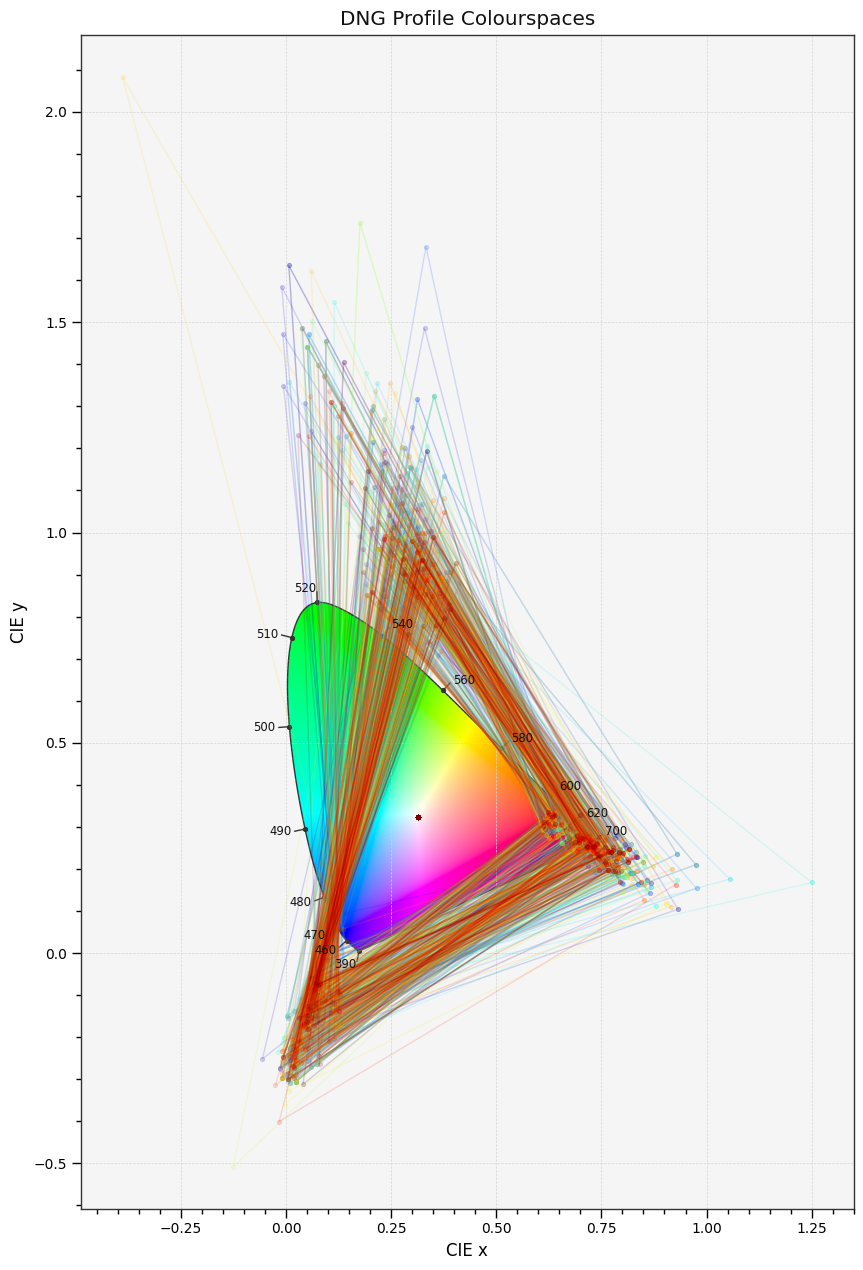

In [ ]:
colour.plotting.plot_RGB_colourspaces_in_chromaticity_diagram_CIE1931(
    [profile['Colourspace2'] for profile in list(DATA_DCP_PROFILES.values())],
    title='DNG Profile Colourspaces',
    colour_cycle_map=plt.get_cmap('jet'),
    plot_kwargs={'alpha': 0.15},
    legend=False,
);

# ACEScg Distance Limits

In [ ]:
def compute_distance_limits(colourspaces):
    extent = np.array([
        [-1,  1,  1],
        [ 1, -1,  1],
        [ 1,  1, -1]
    ])
    
    limits = []
    
    for colourspace in colourspaces:
        RGB = colour.RGB_to_RGB(
            extent, colour.models.RGB_COLOURSPACE_ACESCG, colourspace)
        HSV = colour.RGB_to_HSV(RGB)
        HSV[..., 1] = np.minimum(1, HSV[..., 1])

        RGB = colour.HSV_to_RGB(HSV)

        limits.append(colour.RGB_to_RGB(
            RGB, colourspace, colour.models.RGB_COLOURSPACE_ACESCG))

    achromatic = np.max(limits, axis=-1)[..., np.newaxis]
    distance = np.where(achromatic == 0, 0, (achromatic - limits) / achromatic)

    return distance


C, M, Y = colour.utilities.tsplit(compute_distance_limits(
    [profile['Colourspace2'] for profile in list(DATA_DCP_PROFILES.values())]))

print('\nDistance Limits:')
print(np.max(C) - 1, np.max(M) - 1, np.max(Y) - 1)


Distance Limits:
0.340550084103 0.803397983528 0.392630884727
